In [1]:
import torch
import pandas as pd
from transformers import AutoTokenizer
from sklearn import preprocessing

LABELS = [
            'anticipazione',
            'causa',
            'commento',
            'conferma',
            'considerazione',
            'contrapposizione',
            'deresponsabilizzazione',
            'descrizione',
            'dichiarazione di intenti',
            'generalizzazione',
            'giudizio',
            'giustificazione',
            'implicazione',
            'non risposta',
            'opinione',
            'possibilità',
            'prescrizione',
            'previsione',
            'proposta',
            'ridimensionamento',
            'sancire',
            'specificazione',
            'valutazione'
    ]

class HyperionDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer_name):
        #fill_null_features(df)
        df = filter_empty_labels(df)
        df = to_lower_case(df)
        uniform_labels(df)          
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name) 
        self.encodings = tokenize(df, tokenizer)
        self.labels = encode_labels(df).tolist()    

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)   


# Dataset loading and preprocessing
def fill_null_features(df):
        for c in ['Domanda','Testo']:
            for i in range(0,len(df.index)):  
                if not df[c][i]:
                    j=i
                    while j>0: 
                        j-=1
                        if df[c][j]:
                            df[c][i] = df[c][j]
                            break

#Delete examples with empty label
def filter_empty_labels(df):
    filter = df["Repertorio"] != ""
    return df[filter]

#Convert to lower case
def to_lower_case(df):
    return df.applymap(str.lower)


#Lables uniformation uncased
def uniform_labels(df):
    df['Repertorio'].replace('implicazioni','implicazione', inplace=True)
    df['Repertorio'].replace('previsioni','previsione', inplace=True)

def tokenize(df, tokenizer):
    return tokenizer(
        df['Stralcio'].tolist(),
        #df['Domanda'].tolist(),
        max_length=512,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

def encode_labels(df):
    le = preprocessing.LabelEncoder()
    le.fit(LABELS)
    return le.transform(df['Repertorio'])

def decode_labels(encoded_labels):
    le = preprocessing.LabelEncoder()
    le.fit(LABELS)
    return le.inverse_transform(encoded_labels)

def train_val_split(df, tok_name,  val_perc=0.1):
    gb = df.groupby('Repertorio')
    train_list = []
    val_list = []

    for x in gb.groups:
        class_df = gb.get_group(x)

        # Validation set creation
        val = class_df.sample(frac=val_perc)
        train = pd.concat([class_df,val]).drop_duplicates(keep=False)

        #train_list.append(train.head(500))
        train_list.append(train)
        val_list.append(val)

    train_df = pd.concat(train_list)
    val_df = pd.concat(val_list)
    return HyperionDataset(train_df, tok_name), HyperionDataset(val_df, tok_name)

In [2]:
df = pd.read_csv('../data/Original_csv/Hyperion.csv', na_filter=False)
tok_name = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"

train_dataset, val_dataset = train_val_split(df.head(100), tok_name)

In [3]:
#Deterministic mode
def seed_everything(seed=1464):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [4]:
import neptune.new as neptune

class NeptuneLogger():
    def __init__(self) -> None:
        #Neptune initialization
        self.run = neptune.init(
            project="mibo8/Rep",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZmRkYThiZi1mZGNlLTRlMTktODQwNS1hNWFlMWQ2Mjc4N2IifQ==",
        )
    

In [9]:
import time
import datetime

import torchmetrics
import torch
from torch.utils.data import DataLoader
from transformers import  AdamW



class Trainer():
    def __init__(self, batch_size, lr, n_epochs, ) -> None:
        self.batch_size = batch_size
        self.learning_rate = lr
        self.n_epochs = n_epochs

        self.logger = NeptuneLogger()

        self.metric_collection = torchmetrics.MetricCollection({

            'accuracy_micro' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='micro'),
            'accuracy_macro' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='macro'),
            'accuracy_weighted' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='weighted'),
            'accuracy_none' : torchmetrics.Accuracy(num_classes=23, multiclass=True, average='none'),

            'f1_micro' : torchmetrics.F1(num_classes=23, multiclass=True, average='micro'),
            'f1_macro' : torchmetrics.F1(num_classes=23, multiclass=True, average='macro'),
            'f1_weighted' : torchmetrics.F1(num_classes=23, multiclass=True, average='weighted'),
            'f1_none' : torchmetrics.F1(num_classes=23, multiclass=True, average='none'),

            'precision_micro' : torchmetrics.Precision(num_classes=23, multiclass=True, average='micro'),
            'precision_macro' : torchmetrics.Precision(num_classes=23, multiclass=True, average='macro'),
            'precision_weighted' : torchmetrics.Precision(num_classes=23, multiclass=True, average='weighted'),
            'precision_none' : torchmetrics.Precision(num_classes=23, multiclass=True, average='none'),

            'recall_micro' : torchmetrics.Recall(num_classes=23, multiclass=True, average='micro'),
            'recall_macro' : torchmetrics.Recall(num_classes=23, multiclass=True, average='macro'),
            'recall_weighted' : torchmetrics.Recall(num_classes=23, multiclass=True, average='weighted'),
            'recall_none' : torchmetrics.Recall(num_classes=23, multiclass=True, average='none')
        }) 
        
    def fit(self, model, train_dataset, val_dataset):
        
        params_info = {
            'learning_rate' : self.learning_rate,
            'batch_size' : self.batch_size,
            'n_epochs' : self.n_epochs
        }
        self.logger.run['params'] = params_info

        torch.cuda.empty_cache()
        #----------TRAINING

        # Measure the total training time for the whole run.
        total_t0 = time.time()

        epochs = self.n_epochs

        # Creation of Pytorch DataLoaders with shuffle=True for the traing phase
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        validation_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)

        #Adam algorithm optimized for tranfor architectures
        optimizer = AdamW(model.parameters(), lr=self.learning_rate)

        # Scaler for mixed precision
        scaler = torch.cuda.amp.GradScaler()

        # Setup for training with gpu
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

        # For each epoch...
        for epoch_i in range(0, epochs):
            
            # ========================================
            #               Training
            # ========================================
            
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode: Dropout layers are active
            model.train()
            
            # For each batch of training data...
            for step, batch in enumerate(train_dataloader):

                # Progress update every 40 batches.
                if step % 10 == 0 and not step == 0:
                    # Compute time in minutes.
                    elapsed = format_time(time.time() - t0)
                    
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

                # Unpack this training batch from the dataloader. 
                #
                #  copy each tensor to the GPU using the 'to()' method
                #
                # 'batch' contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

                # clear any previously calculated gradients before performing a
                # backward pass
                model.zero_grad()  


                # Perform a forward pass in mixed precision
                with torch.cuda.amp.autocast():
                    outputs = model(b_input_ids, 
                                    attention_mask=b_input_mask, 
                                    labels=b_labels)
                
                loss = outputs[0]
                logits = outputs[1]

                # Move logits and labels to CPU
                logits = logits.detach().cpu()
                label_ids = b_labels.to('cpu')

                batch_metric = self.metric_collection.update(logits, label_ids)
                #print(batch_metric)

                # Perform a backward pass to compute the gradients in MIXED precision
                scaler.scale(loss).backward()

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end.
                total_train_loss += loss.item()

                # Unscales the gradients of optimizer's assigned params in-place before the gradient clipping
                scaler.unscale_(optimizer)

                # Clip the norm of the gradients to 1.0.
                # This helps and prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters and take a step using the computed gradient in MIXED precision
                scaler.step(optimizer)
                scaler.update()


            # Compute the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(train_dataloader)

            final_metrics = self.metric_collection.compute()
            print(final_metrics)
            
            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.3f}".format(avg_train_loss))
            print("  Training epoch took: {:}".format(training_time))

            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure performance on
            # the validation set.

            print("")
            print("Running Validation...")

            self.metric_collection.reset()
            t0 = time.time()

            # Put the model in evaluation mode: the dropout layers behave differently
            model.eval()

            total_val_loss = 0

            # Evaluate data for one epoch
            for batch in validation_dataloader:
                
                # Unpack this training batch from our dataloader. 
                #
                # copy each tensor to the GPU using the 'to()' method
                #
                # 'batch' contains three pytorch tensors:
                #   [0]: input ids 
                #   [1]: attention masks
                #   [2]: labels 
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for training.
                with torch.no_grad():        

                    # Forward pass, calculate logits
                    # argmax(logits) = argmax(Softmax(logits))
                    outputs = model(b_input_ids, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
                    loss = outputs[0]
                    logits = outputs[1]
                    
                # Accumulate the validation loss.
                total_val_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu()
                label_ids = b_labels.to('cpu')

                # metric on current batch
                batch_metric = self.metric_collection.update(logits.softmax(dim=1), label_ids)

            # Report the final metrics for this validation phase.
            # metric on all batches using custom accumulation from torchmetrics library

            final_metrics = self.metric_collection.compute()
            print('VALIDATION: ')
            print(final_metrics)
            # Compute the average loss over all of the batches.
            avg_val_loss = total_val_loss / len(validation_dataloader)
            
            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)
            
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))


        print("")
        print("Training complete!")

        print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
                
    

In [10]:
trainer = Trainer(2, 1e-5, 1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_string = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
tokenizer = AutoTokenizer.from_pretrained(model_string)
model = AutoModelForSequenceClassification.from_pretrained(model_string, num_labels=23)

Some weights of the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [12]:
trainer.fit(model,train_dataset, val_dataset)

/home/michele/anaconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/tmp/ipykernel_19040/2032609219.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/michele/anaconda3/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



======== Epoch 1 / 1 ========
Training...
  Batch    10  of     47.    Elapsed: 0:00:18.
  Batch    20  of     47.    Elapsed: 0:00:36.
  Batch    30  of     47.    Elapsed: 0:00:54.
  Batch    40  of     47.    Elapsed: 0:01:11.


{'accuracy_macro': tensor(0.0774), 'accuracy_micro': tensor(0.1489), 'accuracy_none': tensor([   nan, 0.0000, 0.6250, 0.7500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000,
           nan, 0.0000, 0.0000, 0.0000, 0.0000]), 'accuracy_weighted': tensor(0.1489), 'f1_macro': tensor(0.0376), 'f1_micro': tensor(0.1489), 'f1_none': tensor([   nan, 0.0000, 0.3390, 0.1176, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000,
           nan, 0.0000, 0.0000, 0.0000, 0.0000]), 'f1_weighted': tensor(0.0769), 'precision_macro': tensor(0.0379), 'precision_micro': tensor(0.1489), 'precision_none': tensor([   nan, 0.0000, 0.2326, 0.0638, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000,
           nan, 0.0000, 0.0000, 0.0000, 0.0000]), 'precision_weighted': tensor(0.0636), 'recall_macro': tensor(

In [34]:

import matplotlib.pyplot as plt

def plot_loss(loss, val_loss):
  plt.figure(figsize=(10,6))
  plt.xticks(range(1,len(loss)+1))
  plt.plot(range(1,len(loss)+1), loss, label='train')
  plt.plot(range(1,len(val_loss)+1), val_loss, label='val')
  plt.title('loss')
  plt.legend()

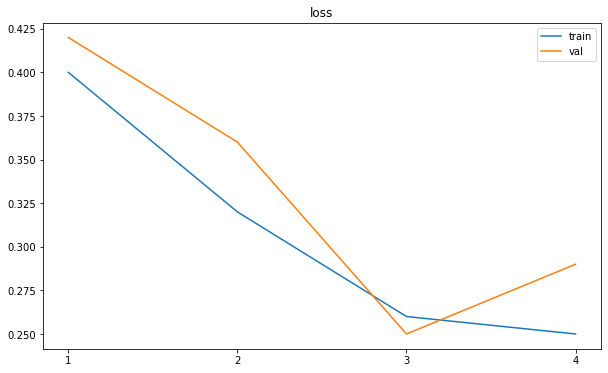

In [35]:
loss = [0.4, 0.32, 0.26, 0.25]
val_loss = [0.42, 0.36, 0.25, 0.29]

plot_loss(loss,val_loss)